# Dosing

This notebook simulates the dosing of the antibiotic Tarzlon. The following steps must be minimally modeled:

0) $T \rightarrow A$ Tarzlon entering the stomach (approximately instantaneous)  
1) $A \rightarrow B$ 1st order, Tarzlon in stomach is transferred to the blood  
2) $A \rightarrow I$ 1st order, Tarzlon in stomach is transferred to the intestine  
3) $B \rightarrow D$ 0th order, Tarzlon in the blood degrades  
4) $B \rightarrow U$ 1st order, Tarzlon in the blood is transferred to urine  

The only concentration we need to track in this case is in the blood. The concentrations of I, D, and U do not need to be tracked since they do not affect B.

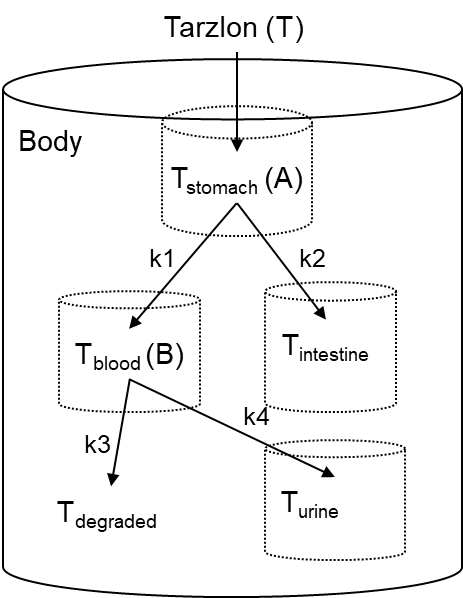

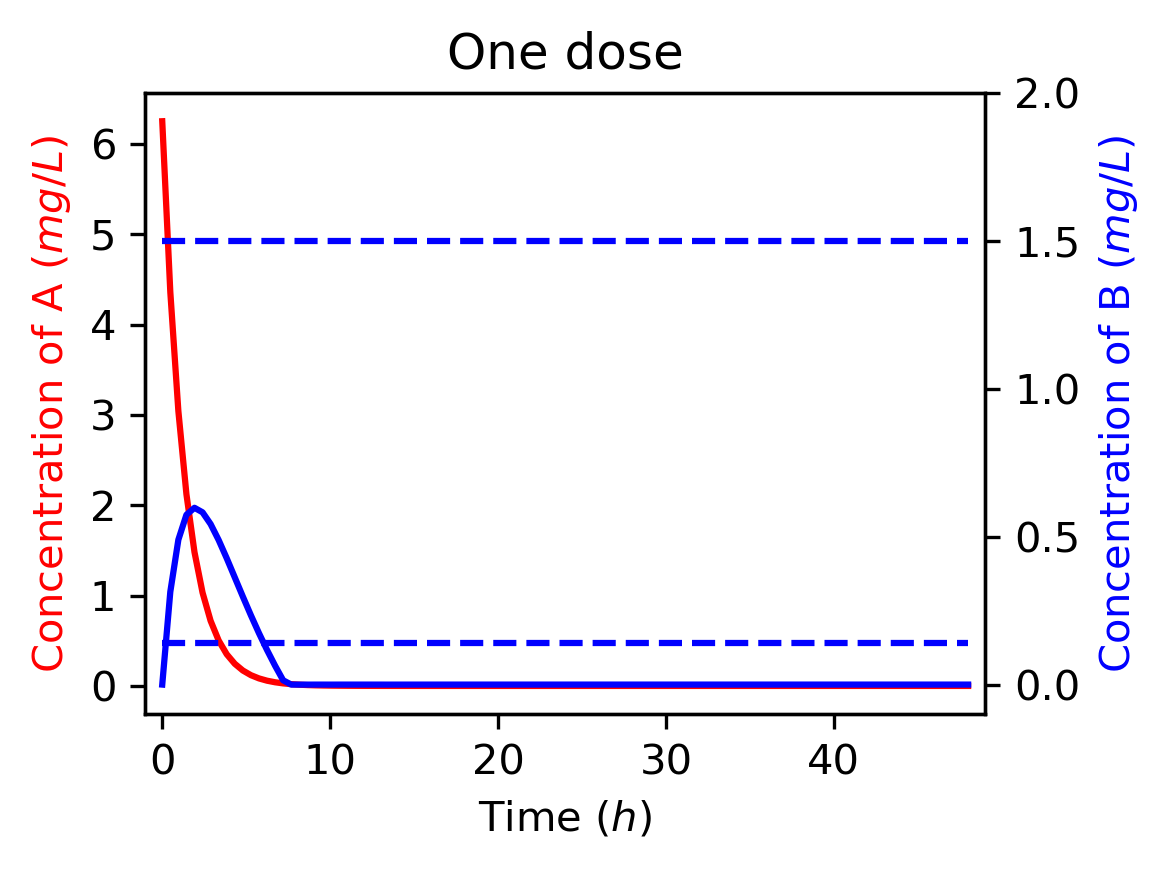

Final CA = 0.000 g/L
Final CAB= -0.000 g/L
Final t = 48.00 h


In [42]:
###### 1. Import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

###### 2. Input dosage details, patient details, kinetics, and target concentrations

### Dose details
m_dose = 250   # mg

### Body volume
V = 40         # L

### Rate constants
k1 = 0.15   # h^-1
k2 = 0.60   # h^-1
k3 = 0.10   # mg / L h  note that this must be set to zero when C_B=0
k4 = 0.2    # h^-1

### Target concentration range
target_low = 0.14    # mg/L
target_high = 1.5    # mg/L

###### 3. Specify dosing profile which contains a list of "adjusted initial conditions"

### Dose schedule
n_doses = [1]    # number of doses at each point
dosage_lengths = [48] # length of time between doses

### Specify initial conditions of first dosage
C_A0 = n_doses[0]*m_dose/V
C_B0 = 0

### First dosage length
tlim=(0,dosage_lengths[0])                      # First dosage duration
tlist = np.linspace(tlim[0],tlim[1],num=101)    # Specify 100 evenly-space intervals between t0 and tfinal of first dosage
U0 = [C_A0,C_B0]                                # Initial concentrations

###### 4. Define the concentration change vs time after a dosage
def dose(t,U):
    
    ### Assign inputs to concentrations
    C_A = U[0]
    C_B = U[1]
    
    ### Note that the the zero-order rate constant must be 0 when there is no reactant to consume
    if C_B > 0:
        k3 = 0.10 # mg / L h
    else:
        k3 = 0      # mg / L h
             
    ### Define reaction rates
    r1 = k1 * C_A
    r2 = k2 * C_A
    r3 = k3
    r4 = k4 * C_B
    
    ### Define production rates of individual species
    R_A = -r1 - r2
    R_B =  r1      - r3 - r4
    
    ### Define differential equations
    dC_A = R_A
    dC_B = R_B
    
    ### Fit equations into array
    dU=np.zeros(len(U))
    dU[0] = dC_A
    dU[1] = dC_B
    
    ### Reorganize list to fit required dimensions 
    dU = np.array(dU).tolist()
    
    return dU

###### 5. Perform piecewise integrations

### Generate first dosage profile
solution = solve_ivp(dose,tlim,U0,t_eval=tlist) # Perform integration
t = solution.t                                  # Store output independendept variable array (time)
U = solution.y.T                                # Store output dependent variable arrays (concentrations)

### Initialize "overall" arrays which track values throughout treatment
C_A_overall = U[:,0]
C_B_overall = U[:,1]
t_overall = t

### Conduct individual doses, update "overall" array

for i,val in enumerate(dosage_lengths):
    
    if i > 0:
        
        ### Define initial dosage concentration based on prior dosage and new number of doses
        C_A0 = C_A_overall[-1] + n_doses[i] * m_dose / V
        C_B0 = C_B_overall[-1]

        ### Generate dosage profile
        tlim=(0,dosage_lengths[i])
        tlist = np.linspace(tlim[0],tlim[1],num=101)
        U0 = [C_A0,C_B0]
        solution = solve_ivp(dose,tlim,U0,t_eval=tlist)
        U = solution.y.T
        t = solution.t
        
        ### Add outputs to "overall" arrays
        C_A_overall = np.concatenate([C_A_overall,U[:,0]])
        C_B_overall = np.concatenate([C_B_overall,U[:,1]])
        t_overall = np.concatenate([t_overall,t+t_overall[-1]])

### Plot treatment profile
fig = plt.figure(figsize=(4,3),dpi=300)
ax1 = plt.subplot(111)

ax1.plot(t_overall,C_A_overall,'r')
ax1.set_xlabel('Time ($h$)')
ax1.set_ylabel('Concentration of A ($mg/L$)',color='red')
ax1.set_xlim([-1,49])
ax1.set_title('One dose')

ax2=ax1.twinx()
ax2.plot(t_overall,C_B_overall,'b')
ax2.plot([t_overall.min(),t_overall.max()],[target_low,target_low],'--b')
ax2.plot([t_overall.min(),t_overall.max()],[target_high,target_high],'--b')
ax2.set_ylabel('Concentration of B ($mg/L$)',color='blue')
ax2.set_ylim([-0.1,2])

fig.tight_layout()
plt.show()

fig.savefig('dosing_figure.png')

print('Final CA =','{0:,.3f}'.format(C_A_overall[-1]),'g/L')
print('Final CAB=','{0:,.3f}'.format(C_B_overall[-1]),'g/L')
print('Final t =','{0:,.2f}'.format(t_overall[-1]),'h')